# 08. Pytorch Paper replicatin

The goal of a machine learning research paper replication is: Turn a ML research paper into usable code

In this notebook, we're going to replicate the vision transformer (VIT)architecture/paper with pytorch

See the research paper here: https://arxiv.org/abs/2010.11929

## 0. Get setup

Let's import code we've previously written + required libraries

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 40.27 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. get data

The whole goal of what we're trying to do is to replicate the VIT architecture for our Foodvision mini problem

To do that,  we need some data

Namely, the pizza, steak, sushi data we've been using.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,  test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

2. ## Create datasets and dataloaders


In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# create an image size
IMAGE_SIZE = 224 # Comes from Table 3 of the VIT paper

# Create transforms pipeline
manual_transform = transforms.Compose([
                                       transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
])

print(f"Manualy created transforms: {manual_transform}")

Manualy created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses a batch size of 4026, this might be too big for our hardware... can always scale up later)
import os
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=os.cpu_count())

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [ ]:
# get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# view the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

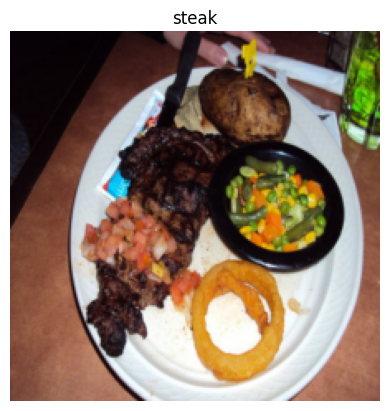

In [ ]:
# plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # matplotlib likes when the color channels is last
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating Vit overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it understandable we can break it down into smaller pieces.

* **inputs** - What goes into the model? (in our case, "food image tensors")
* **outputs** - What comes out of the model/layer/block (in our case,  we want the model to output image classification labels)
* **layers** - Takes an input manipulates it with a function, (for example it could be "self-attention")
* **Blocks** - a collection of layers.
* **Model** - a collection of blocks

### 3.1 VIT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training
* Text

### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embedding = learnable representation (start with random numbers and improve them over time)

### Four equations
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

### Section 3.1 Describes the various equations
**Equation 1.:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1.:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ...., image_patch_N] + [class_token_pos, image_path_1_pos, image_patch_2_pos, ...., image_path_N_pos]
```
---

**Equation 2&3.:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

IN pseudocode:
``` python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```
---

**Equation 4.:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathrm{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = Multilayer perceptron = a neaural network with x number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

IN pseudocode:

``` python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```



### Table 1
![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* VIT-Base, VIT-Large, VIT-Huge are all differnent sizes of the same model architecture.
* Layers - number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture (vector)
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self attention

### 4. Equation 1: Split data into patches and creating the class,  position and patch embedding

Layers = input -> function -> output

Whats the input shape?

Whats the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, weight, color channels)
* output shape:

> **Equation 1.:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1.:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input image: $H\times{W}\times{C}$ (height x width x color channels)
* Output image: ${N \times\left(P^2 \cdot C\right)}$
* $H$ = height
* $W$ = width
* $C$ = color channels
* $P$ = patch size
* $N$ = number of patches = (height * width) / $P^2$
* $D$ = constant latent vector size = embedding dimension (see Table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2d image): {embedding_layer_input_shape}")
print(f"Output shape (single 1d sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimensions)")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1d sequence of patches): (196, 768) -> (number_of_patches, embedding_dimensions)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

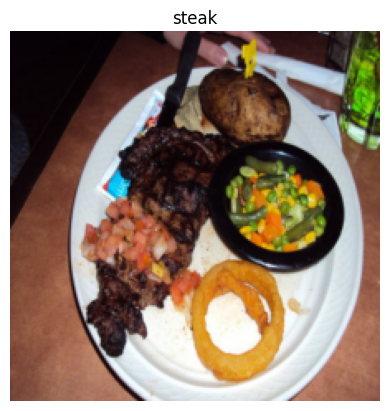

In [ ]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis("off")

In [ ]:
image.shape

torch.Size([3, 224, 224])

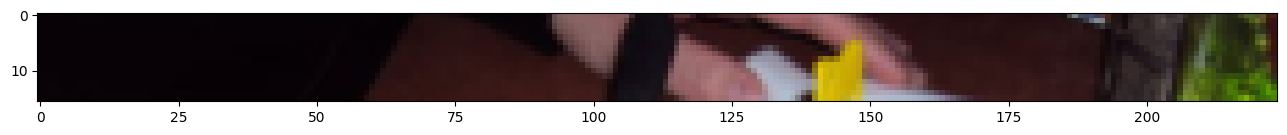

In [ ]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels 


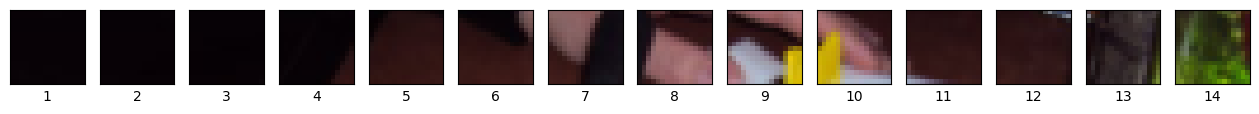

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels ")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                         ncols=img_size // patch_size, # one column for each patch
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

# Iterate through number of patches in the top row
for i,  patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


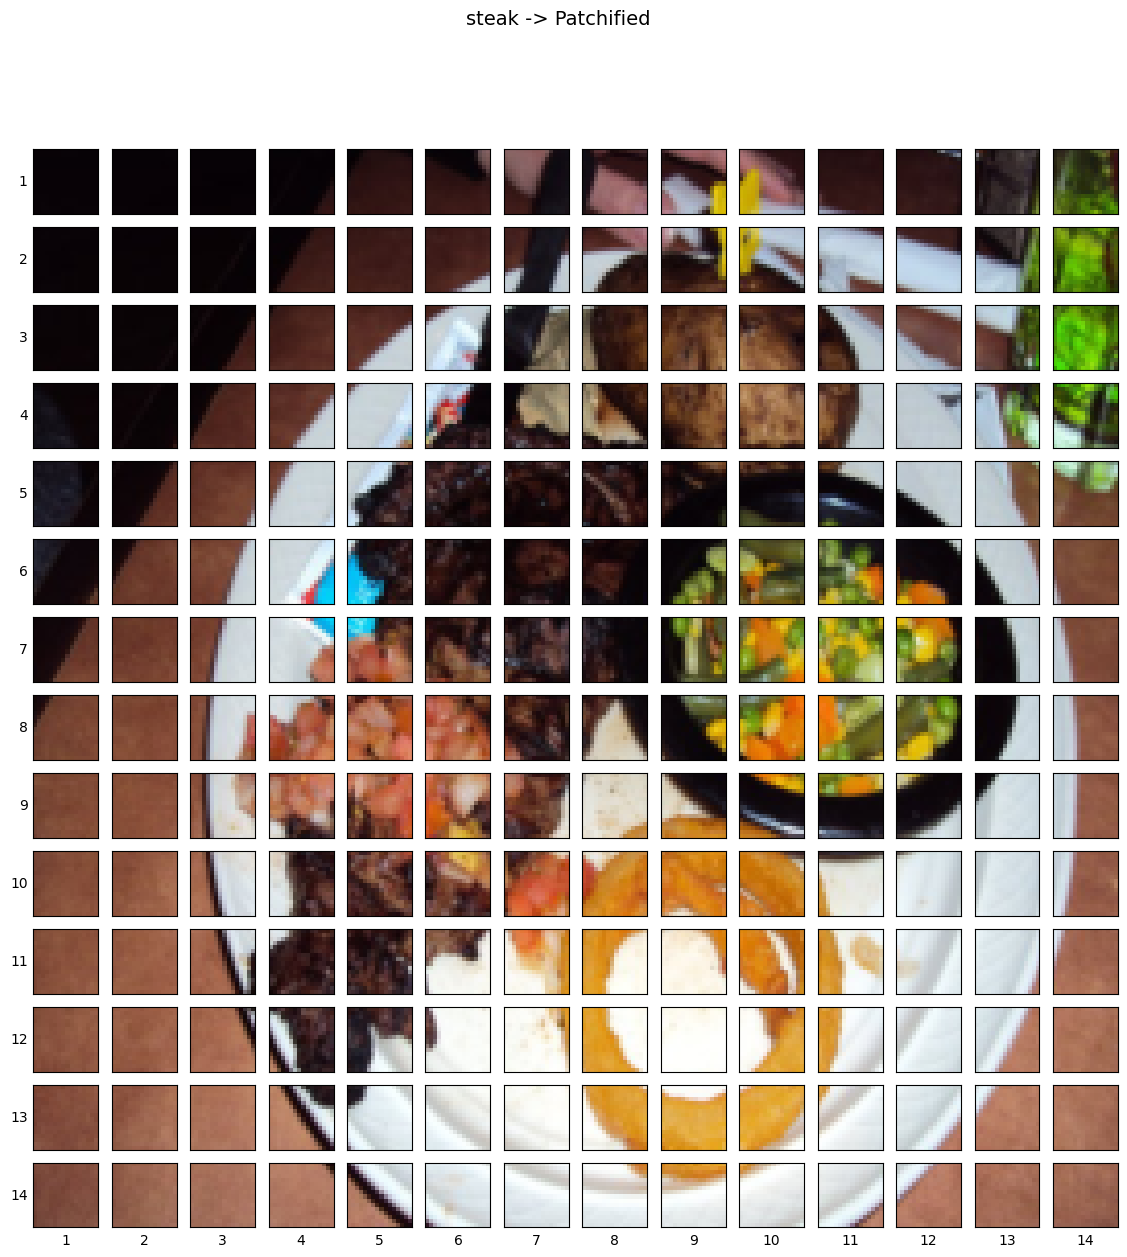

In [ ]:
# Setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size" # or we will get uneven patches
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches * num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through the height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all the color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Crearing image patches and turning them into patch embeddings

Perhaps we could create the images patches and image patch embeddings in a single step using `torch.nn.Conv2d` and setting the kernel size and stride to the `patch_size`

In [ ]:
# Create conv2d layer to turn image into patches into learnable feature maps (embeddings)
from torch import nn

# set the patch size
patch_size = 16

# create a con2d layer with hyperparameters from the Vit paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from table 1 (embedding size)
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

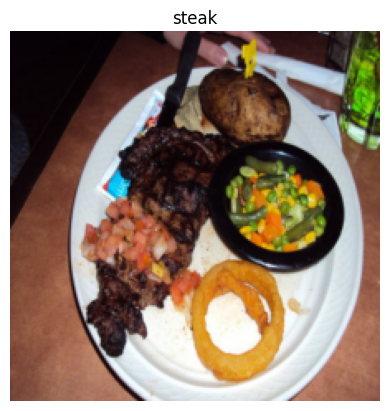

In [ ]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')

In [ ]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # add a batch dimension (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [136, 4, 410, 355, 561]


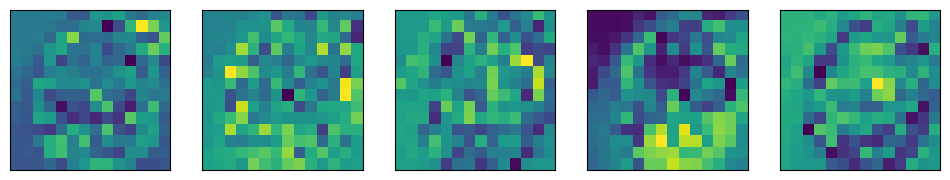

In [ ]:
# Plot random convolutional feature maps (embeddings)
import random

radnom_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {radnom_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                       ncols=5,
                        figsize=(12, 12))

# plto random image faeture maps
for i, idx in enumerate(radnom_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for numpy
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0157, -0.0177, -0.0195, -0.0031,  0.0561,  0.1585,  0.0536,
            0.3433,  0.5939,  0.4210,  0.1522,  0.1058,  0.1002,  0.2601],
          [-0.0133, -0.0166, -0.0178,  0.0389,  0.1010,  0.1226,  0.5633,
            0.3758,  0.0600,  0.1980,  0.6860,  0.8175,  0.7328,  0.2888],
          [-0.0151, -0.0174,  0.0396,  0.1392,  0.6013,  0.6526,  0.3104,
            0.2220,  0.2447,  0.2054,  0.2114,  0.6797,  0.1056,  0.4751],
          [ 0.0472, -0.0104,  0.1474,  0.5195,  0.9037,  0.1530,  0.1534,
            0.3537,  0.1858,  0.3043,  0.5390,  0.8923,  0.8103,  0.5054],
          [ 0.0781,  0.1001,  0.2750,  0.8359,  0.4500,  0.0927,  0.0152,
            0.0525,  0.0532,  0.0680,  0.2252,  0.5264,  0.7801,  0.2732],
          [ 0.0616,  0.2217,  0.4962,  0.9048,  0.6372,  0.0779,  0.0204,
            0.0272,  0.1129,  0.3123,  0.3497,  0.2875,  0.3369,  0.3456],
          [ 0.1486,  0.2552,  0.4514,  0.7150,  0.5528,  0.2471,  0.1226,
            0.0502,  0.1144,  0.

### 4.4 Flattening the patch embedding with `torch.nn.FLatten()`

Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the VIt transformer

In [ ]:
print(f"{image_out_of_conv.shape} [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: (batch_size, number_of_patches, embedding_dim)

In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, # embedding_dim
                           end_dim=3) # feature_map_width

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


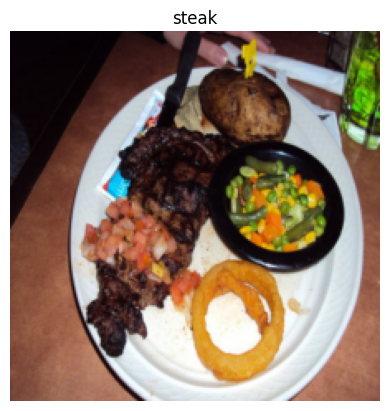

In [ ]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a batch dimension
print(f"Image feature map (patches) shape {image_out_of_conv.shape}")

# flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> [batch_size, number_of_patches, embedding_dim]")

torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dim]


(-0.5, 195.5, 0.5, -0.5)

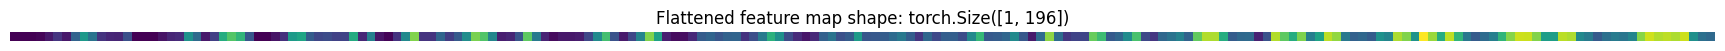

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the Vit patch embedding layer into a Pytorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`.
2. Initialize with appropriate hyperpatameters, suzh as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d`
4. Create a layer to flatten the feature maps of the output of the layer in 3
5. Ddefine a `foward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [ ]:
# 1. Create a class
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from table 1 for Vit-base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

    # 5. Define a forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, num_batches, embedding)
    return x_flattened.permute(0, 2, 1)


In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

want to: prepend a learnable class token to the start of the patch embedding.

In [ ]:
patch_embedded_image

tensor([[[-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         [-0.0384, -0.0113, -0.0307,  ...,  0.0202, -0.0132,  0.0107],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# create class token embedding as a learnable parameter that shares the same as the embedding dimension (D)

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension,
                                      requires_grad=True)) # This is set by defeault

class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)  # number of patches dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class tokens prepended with class token preprended shape {patch_embedded_image_with_class_embedding.shape} -> [batch_size, class_token + num_patches, embedding_dim]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
         [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
         ...,
         [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
         [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
         [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class tokens prepended with class token preprended shape torch.Size([1, 197, 768]) -> [batch_size, class_token + num_patches, embedding_dim]


### 4.7 Creating the position embedding

Want to: create a series of 1d learnable position embeddings and to add them to the sequence of patch embeddings


In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0429, -0.0113, -0.0323,  ...,  0.0222, -0.0138,  0.0130],
          [-0.0417, -0.0110, -0.0316,  ...,  0.0199, -0.0131,  0.0109],
          ...,
          [-0.5905, -0.0231, -0.0038,  ...,  0.4907, -0.4757,  0.2497],
          [-0.5391,  0.0619, -0.0972,  ...,  0.3296, -0.2619,  0.2086],
          [-0.5006,  0.0595, -0.0813,  ...,  0.3091, -0.2577,  0.2046]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
# Create N [number of patchches]
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9571, 0.9887, 0.9677,  ..., 1.0222, 0.9862, 1.0130],
         [0.9583, 0.9890, 0.9684,  ..., 1.0199, 0.9869, 1.0109],
         ...,
         [0.4095, 0.9769, 0.9962,  ..., 1.4907, 0.5243, 1.2497],
         [0.4609, 1.0619, 0.9028,  ..., 1.3296, 0.7381, 1.2086],
         [0.4994, 1.0595, 0.9187,  ..., 1.3091, 0.7423, 1.2046]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together: from image to embedding

we've written code to turn an image in a flattened sequence of patch embeddings

Now let's see it all in one cell.

In [ ]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create the patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[2]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension,
                                      requires_grad=True))
print(f"Class token embedding shape: {class_token.shape}")

# 7. prepend the class token embedding to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create the position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead Self-Attention (MSA block)
* MUltihead self-attention: Which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (VIT) to learn this relationship/representation.
* To replicate MSA in PyTorch we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* Layernorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation
  * In pytorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
  * When we normalize along the embedding dimension, it's like making all of the stairs in the staircase the same size

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short)"""
  def __init__(self,
               embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for VIT-base
               num_heads:int=12,
               attn_dropout:int=0): # Heads from table 1
    super().__init__()
    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead self attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     dropout=attn_dropout,
                                                     batch_first=True) # is the batch first? (batch, sequence, feature) -> (batch, number_patches, embedding_dim

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output



In [ ]:
# Create an instance of our MSA block
multihead_self_attn_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                        num_heads=12,
                                                        attn_dropout=0)

# Pass the patch and position image embedding sequence through the MSA block
patched_image_through_msa_block = multihead_self_attn_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9571, 0.9887, 0.9677,  ..., 1.0222, 0.9862, 1.0130],
         [0.9583, 0.9890, 0.9684,  ..., 1.0199, 0.9869, 1.0109],
         ...,
         [0.4095, 0.9769, 0.9962,  ..., 1.4907, 0.5243, 1.2497],
         [0.4609, 1.0619, 0.9028,  ..., 1.3296, 0.7381, 1.2086],
         [0.4994, 1.0595, 0.9187,  ..., 1.3091, 0.7423, 1.2046]]],
       grad_fn=<AddBackward0>)

In [ ]:
patched_image_through_msa_block

tensor([[[-0.1750, -0.2088,  0.0847,  ..., -0.4122,  0.8395, -0.4527],
         [-0.1724, -0.2172,  0.0938,  ..., -0.3863,  0.8421, -0.4629],
         [-0.1721, -0.2186,  0.0925,  ..., -0.3867,  0.8415, -0.4639],
         ...,
         [-0.1562, -0.1946,  0.0940,  ..., -0.4021,  0.8555, -0.4683],
         [-0.1547, -0.1956,  0.0966,  ..., -0.3997,  0.8549, -0.4703],
         [-0.1554, -0.1969,  0.0956,  ..., -0.3992,  0.8551, -0.4702]]],
       grad_fn=<TransposeBackward0>)

## 6. Equation 3: MUltilayer perceptron block

* **MLP** = The MLP contains two layers with a GELU non-linearity (sectioon 3.1).
  * MLP = a quite broad term for a block with a series of layers, layers can be multiple or even one hidden layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In Pytorch, they're often called `torch.nn.Linear()` and in tensorflow they might be called `tf.kerras.layers.Dense()`
  * GELU in pytorch -https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden units = MLP size in Table 1
* **DropOut** = when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  * Value for dropout can be found on Table 3

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```



In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of the mlp shape: {patched_image_through_msa_block.shape}")
print(f"output shape of the mlp shape: {patched_image_through_mlp_block.shape}")

Input shape of the mlp shape: torch.Size([1, 197, 768])
output shape of the mlp shape: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block

tensor([[[-0.1750, -0.2088,  0.0847,  ..., -0.4122,  0.8395, -0.4527],
         [-0.1724, -0.2172,  0.0938,  ..., -0.3863,  0.8421, -0.4629],
         [-0.1721, -0.2186,  0.0925,  ..., -0.3867,  0.8415, -0.4639],
         ...,
         [-0.1562, -0.1946,  0.0940,  ..., -0.4021,  0.8555, -0.4683],
         [-0.1547, -0.1956,  0.0966,  ..., -0.3997,  0.8549, -0.4703],
         [-0.1554, -0.1969,  0.0956,  ..., -0.3992,  0.8551, -0.4702]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
patched_image_through_mlp_block

tensor([[[-0.0610, -0.0093,  0.1542,  ..., -0.0000, -0.1507,  0.2167],
         [-0.1052, -0.1293,  0.2689,  ..., -0.1081, -0.1361,  0.2322],
         [-0.0226, -0.0576,  0.2902,  ..., -0.0000, -0.2047,  0.2181],
         ...,
         [-0.1901, -0.0166,  0.2585,  ...,  0.1049, -0.2112,  0.3065],
         [-0.1248,  0.0412,  0.0000,  ...,  0.0467, -0.1801,  0.0990],
         [-0.0707, -0.0360,  0.2206,  ..., -0.1166, -0.1543,  0.2042]]],
       grad_fn=<MulBackward0>)

## 7. Creating the transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

And there are residual connections between each block

* Encoder = turn a sequence into a learnable representation
* Decoder = go from learned representation back to some sort of sequence
* Residual connections = add a layers input to its subsequent output, this enables the creation of deeper networks and (prevents weights from getting too small)

In pseudocode:

```python
# Transformer encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom transformer encoder block

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table 1, 768 for VIT-Base
               num_heads:int=12, # from table 1
               mlp_size:int=3072, # from table 1
               mlp_dropout:int=0.1,
               attn_dropout:int=0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual connection/skip connection for equation 2
    x = self.mlp_block(x) + x # residual connection/skip connection for equation 3
    return x

In [ ]:
# Create an instance of TransformerEncoderBLock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batche_size, num_patches, embedding_dim) output of the embedded patches not the size of the image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-built Pytorch layers

So far we've created a transformer encoder by hand

But because of how good the transformer architecure is,  Pytorch has implemented ready to use transformer encoder layers: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#transformer

We can create a transformer Encoder with pure Pytorch layers


In [ ]:
#  Create a transformer with torch.nn.TransformerEncoderLayer()

torch_transformer_encoder_layer = torch.nn.TransformerEncoderLayer(d_model=768, # embedding dimension from table 1
                                                                   nhead=12,  # number of heads
                                                                   dim_feedforward=3072, # MLP size from table one
                                                                   dropout=0.1,
                                                                   activation="gelu",
                                                                   batch_first=True,
                                                                   norm_first=True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batche_size, num_patches, embedding_dim) output of the embedded patches not the size of the image
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Now we know how things are implemented behind the scenes, we can tweak them if its necessary.

What are the benefits of using a pre-built Pytorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benefits of speed ups (performance boost)

## 8. Putting it all together to create VIT

In [ ]:
# Create a Vit class
class VIT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the vit paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "layers" in Vit-Base
               embedding_dim:int=768, # hidden size d from table 1 for VIT-base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # Number of classes in our classification problem
    super().__init__()

    # Make an aseertion that the image size is compatiple with the patch size
    assert img_size % patch_size == 0,  f"image size must be divisible by patch_size, image: {img_size}, patch_size {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create the classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch_size
    batch_size = x.shape[0]

    # Create the class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)# "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat the class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # ([batch_size, number_of_patches + 1, embedding_dim])

    # Add the position embedding to the class_token and the patch embedding
    x = self.position_embedding + x

    # Apply dropout to the patch embeddings ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch and patch embedding to Transformer encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # put 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [ ]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                               requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [ ]:
vit = VIT()
vit

VIT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [ ]:
set_seeds()

# Create a random image tensor with same shape as single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of VIT with the number of classes we're working with (pizza, steak, sushi)
vit = VIT(num_classes=len(class_names))

# pass the random image tensor to our VIT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Getting a visual summary of our VIT model

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo.summary
summary(model=VIT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batche_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom Vit

we've replicated the VIT architecture, now lets see how it performs on our FoodVistion Mini data.

### 9.1 Creating an optimizer
The paper states it uses the Adam optimizer (section 4, Training and fine-tuning):
With $B1$ value of 0.9, and $B2$ of 0.999 (defaults) and a weight decay of 0.1

Weight decay = or L 2 Regularization, is a regularization technique applied to the weights of a neural network. We minimize a loss function compromising both the primary loss function and a penalty on the L 2 Norm of the weights

Regularization technique = prevents overfitting.

In [ ]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3, # 0.001
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The Vit paper doesn't actually mention what loss function they used.

So since it's a multi-class classification problem we will use `torch.nn.CrossEntropyLoss()`

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training Our VIT model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

ptimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3, # 0.001
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


### 9.4 What our training setup is missing

How is our training setup different to the VIT paper?

We've replicated model architecture correctly.

But what was different between our training procedure (to get such poor results) and the VIT paper to get such great results?

The main things our training implemetation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Gradient clipping - prevent gradients from getting too big (to prevent overfitting the model)
* Learning rate warmup - start with a low learning rate and increase to a base learning rate
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate

### 9.5 Plotting lose curves for our model

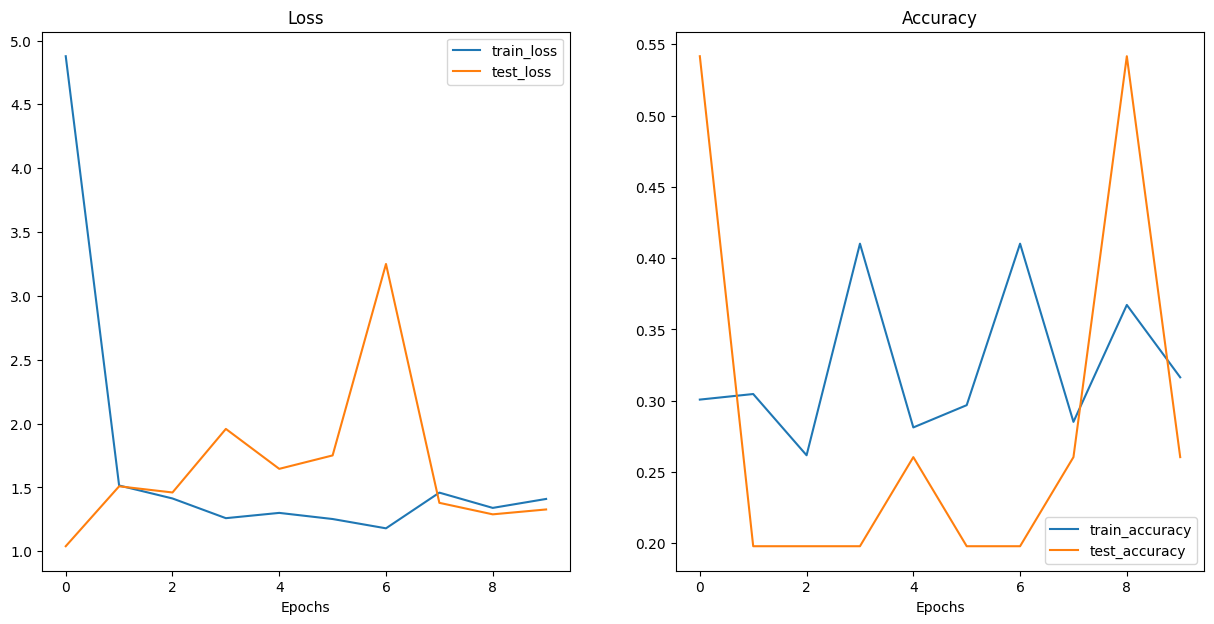

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretrained VIT from `torchvision.models`

generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, its often a good place to start.

If you can find a pretrained model, and use transfer learning, give it a go, it often achieves great results with little data.

**Why use a pretrained model?**

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)

### 10.2 Prepare a pretrained VIT for use with FoodVision Mini (turn it into a feature extractor)

In [ ]:
# get pretrained weights for ViT-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # Default means best available weights

# Set up a Vit model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.9MB/s]


In [ ]:
pretrained_vit.heads

Linear(in_features=768, out_features=3, bias=True)

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo.summary
summary(model=pretrained_vit,
       input_size=(1, 3, 224, 224), # (batche_size, color_channels, height, width)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 preparing data for the pretrained VIT model

In [ ]:
# Get automatic transforms from pretrained VIT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Set up dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Could set a higher batch size with a pretrained model

### 10.4 Train feature extractor VIT model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(pretrained_vit.parameters(),
                             lr=1e-3, # 0.001
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7662 | train_acc: 0.7188 | test_loss: 0.5440 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3442 | train_acc: 0.9453 | test_loss: 0.3269 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2081 | train_acc: 0.9531 | test_loss: 0.2718 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1576 | train_acc: 0.9609 | test_loss: 0.2438 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1268 | train_acc: 0.9727 | test_loss: 0.2297 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1258 | train_acc: 0.9766 | test_loss: 0.2152 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0981 | train_acc: 0.9766 | test_loss: 0.2396 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0854 | train_acc: 0.9844 | test_loss: 0.2311 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1166 | train_acc: 0.9883 | test_loss: 0.2084 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0741 | train_acc: 0.9922 | test_loss: 0.1813 | test_acc: 0.9176


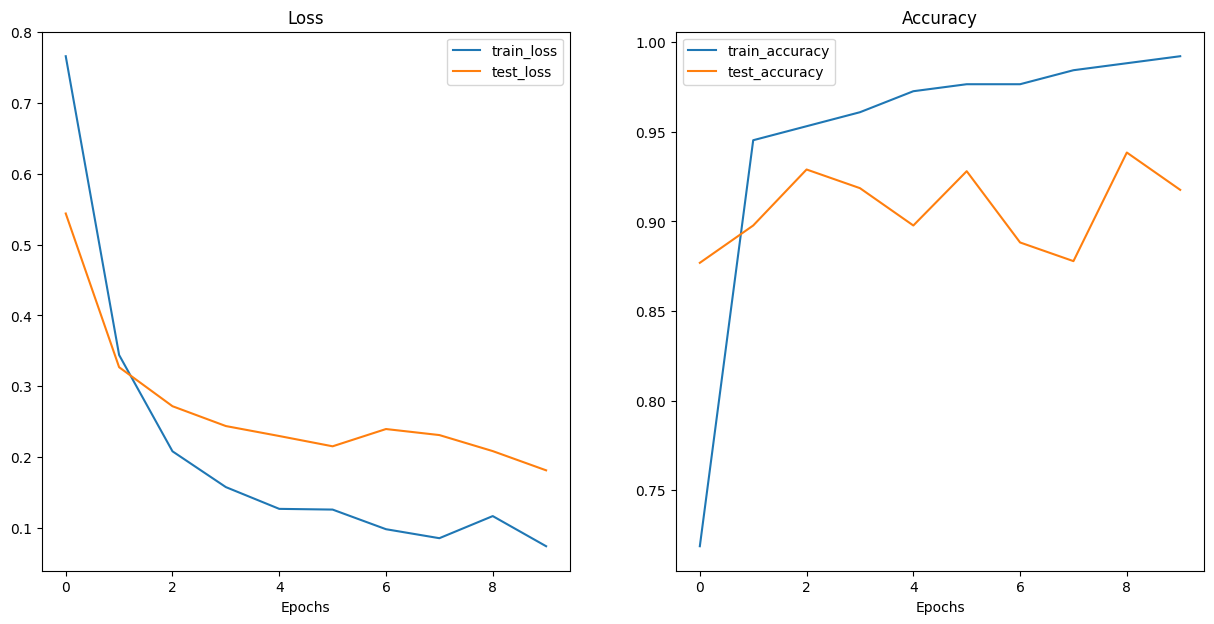

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_results)

### 10.5 Save our best performing VIT model

Now we've got a model that performs quite well, how about we save it to file and then check its file size.

We want to check the filesize because if we wanted to deploy a model to say a website/mobile application we may have limitations of the size of the model that we can deploy.

E.G a smaller model may be required due to compute resrictions

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"pretrained Vit feature extractor model size: {pretrained_vit_model_size} megbytes")

pretrained Vit feature extractor model size: 327 megbytes


Our pretrained VIT gets some of the best results we've seen so far on our foodvision mini data problem however, the model size is 11x larger than our next best performing model.

perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/might not make predictions as fast as a smaller model)

## 11. Predicting on a custom image

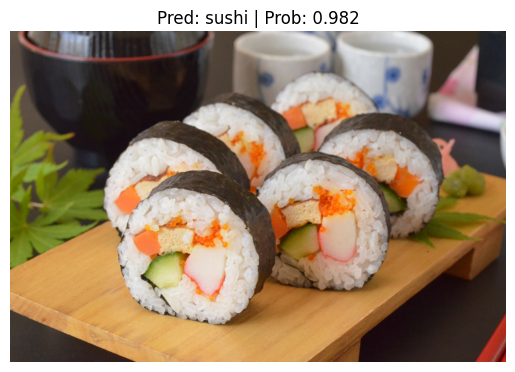

In [ ]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "01-sushi-google.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    url = "https://asianinspirations.com.au/wp-content/uploads/2021/03/How-to-make-your-own-sushi-rolls_00-Feat-Img.jpg"
    request = requests.get(url)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

## Excercises and extra curriculum

### 1. Replicate the ViT architecture we created with in-built PyTorch transformer layers.
You'll want to look into replacing our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
You can stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder().

In [ ]:
# Create a Vit class
class VIT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the vit paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "layers" in Vit-Base
               embedding_dim:int=768, # hidden size d from table 1 for VIT-base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=3): # Number of classes in our classification problem
    super().__init__()

    # Make an aseertion that the image size is compatiple with the patch size
    assert img_size % patch_size == 0,  f"image size must be divisible by patch_size, image: {img_size}, patch_size {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                          nhead=num_heads,
                                                          dim_feedforward=mlp_size,
                                                          dropout=mlp_dropout)

    self.transformer_encoder_block = nn.TransformerEncoder(encoder_layer=self.transformer_encoder_layer,
                                                           num_layers=num_transformer_layers)

    # Create the classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch_size
    batch_size = x.shape[0]

    # Create the class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)# "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat the class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # ([batch_size, number_of_patches + 1, embedding_dim])

    # Add the position embedding to the class_token and the patch embedding
    x = self.position_embedding + x

    # Apply dropout to the patch embeddings ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch and patch embedding to Transformer encoder (equation 2 & 3)
    x = self.transformer_encoder_block(x)

    # put 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

In [ ]:
vit = VIT()
vit

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


VIT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=3072, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=3072, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder_block): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo.summary
summary(model=VIT(),
        input_size=(1, 3, 224, 224), # (batche_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                               [1, 3, 224, 224]     [1, 3]               7,239,936            True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder_block)        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

### 2. Turn the custom ViT architecture we created into a Python script, for example, vit.py.
* You should be able to import an entire ViT model using something likefrom vit import ViT.
* We covered the art of turning code cells into Python scrips in 05. PyTorch Going Modular.


In [ ]:
import os
os.makedirs("vit")

In [ ]:
%%writefile ViT.py
"""
Creates an instance of the VIT architecture (vision transformer)
from the AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE paper
"""

import torch
from torch import nn

# 1. Create a class
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from table 1 for Vit-base
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

    # 5. Define a forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the returned sequence embedding dimensions are in the right order (batch_size, num_batches, embedding)
    return x_flattened.permute(0, 2, 1)


class VIT(nn.Module):
  def __init__(self,
               img_size:int=224, # Table 3 from the vit paper
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12, # Table 1 for "layers" in Vit-Base
               embedding_dim:int=768, # hidden size d from table 1 for VIT-base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, # Dropout for patch and position embeddings
               num_classes:int=3): # Number of classes in our classification problem
    super().__init__()

    # Make an aseertion that the image size is compatiple with the patch size
    assert img_size % patch_size == 0,  f"image size must be divisible by patch_size, image: {img_size}, patch_size {patch_size}"

    # Calculate the number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the transformer encoder block
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                          nhead=num_heads,
                                                          dim_feedforward=mlp_size,
                                                          dropout=mlp_dropout)

    self.transformer_encoder_block = nn.TransformerEncoder(encoder_layer=self.transformer_encoder_layer,
                                                           num_layers=num_transformer_layers)

    # Create the classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get the batch_size
    batch_size = x.shape[0]

    # Create the class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)# "-1" means to infer the dimensions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat the class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # ([batch_size, number_of_patches + 1, embedding_dim])

    # Add the position embedding to the class_token and the patch embedding
    x = self.position_embedding + x

    # Apply dropout to the patch embeddings ("directly after adding positional - to patch embeddings")
    x = self.embedding_dropout(x)

    # Pass position and patch and patch embedding to Transformer encoder (equation 2 & 3)
    x = self.transformer_encoder_block(x)

    # put 0th index logit through the classifier (equation 4)
    x = self.classifier(x[:, 0])

    return x

Writing ViT.py


In [ ]:
!python ViT.py

In [ ]:
from ViT import VIT
imported_vit = VIT()
imported_vit

VIT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (linear1): Linear(in_features=768, out_features=3072, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=3072, out_features=768, bias=True)
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder_block): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_

### 3. Train a pretrained ViT feature extractor model (like the one we made in 08. PyTorch Paper Replicating section 10) on 20% of the pizza, steak and sushi data like the dataset we used in 07. PyTorch Experiment Tracking section 7.3
See how it performs compared to the EffNetB2 model we compared it to in 08. PyTorch Paper Replicating section 10.6.

In [ ]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
train_20_percent_path = data_20_percent_path / "train"
test_20_percent_path = data_20_percent_path / "test"

train_20_percent_path, test_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_20_percent_path,
                                                                                                     test_dir=test_20_percent_path,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d919412ada0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
results_20_percent = engine.train(model=pretrained_vit,
                                  train_dataloader=train_dataloader_20_percent,
                                  test_dataloader=test_dataloader_20_percent,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=10,
                                  device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1128 | train_acc: 0.9792 | test_loss: 0.0896 | test_acc: 0.9847
Epoch: 2 | train_loss: 0.0952 | train_acc: 0.9833 | test_loss: 0.0812 | test_acc: 0.9784
Epoch: 3 | train_loss: 0.0850 | train_acc: 0.9833 | test_loss: 0.0783 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.0764 | train_acc: 0.9833 | test_loss: 0.0763 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.0724 | train_acc: 0.9896 | test_loss: 0.0726 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0693 | train_acc: 0.9896 | test_loss: 0.0723 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0631 | train_acc: 0.9938 | test_loss: 0.0723 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0818 | train_acc: 0.9958 | test_loss: 0.0726 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0631 | train_acc: 0.9938 | test_loss: 0.0848 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0592 | train_acc: 0.9958 | test_loss: 0.0704 | test_acc: 0.9875


### 4. Try repeating the steps from excercise 3 but this time use the "ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1" pretrained weights from torchvision.models.vit_b_16().
Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights .transforms() method.

In [ ]:
swag_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit_swag = torchvision.models.vit_b_16(weights=swag_weights)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:07<00:00, 48.3MB/s]


In [ ]:
pretrained_vit_swag

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
swag_transforms = swag_weights.transforms()

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo.summary
summary(model=pretrained_vit_swag,
       input_size=(1, 3, 384, 384), # (batche_size, color_channels, height, width)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     590,592              True
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              True
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 577, 768

In [ ]:
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

pretrained_vit_swag.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

In [ ]:
from torchinfo import summary

# Get a summary using torchinfo.summary
summary(model=pretrained_vit_swag,
       input_size=(1, 3, 384, 384), # (batche_size, color_channels, height, width)
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [ ]:
train_dataloader_20_percent_swag, test_dataloader_20_percent_swag, class_names = data_setup.create_dataloaders(train_dir=train_20_percent_path,
                                                                                                               test_dir=test_20_percent_path,
                                                                                                               transform=swag_transforms,
                                                                                                               batch_size=32)

train_dataloader_20_percent_swag, test_dataloader_20_percent_swag, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d9190138190>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                           train_dataloader=train_dataloader_20_percent_swag,
                                           test_dataloader=test_dataloader_20_percent_swag,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           epochs=10,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1348 | train_acc: 0.9625 | test_loss: 0.0297 | test_acc: 0.9909
Epoch: 2 | train_loss: 0.0431 | train_acc: 0.9917 | test_loss: 0.0173 | test_acc: 0.9909
Epoch: 3 | train_loss: 0.0245 | train_acc: 0.9979 | test_loss: 0.0134 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0186 | train_acc: 0.9979 | test_loss: 0.0124 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0158 | train_acc: 0.9979 | test_loss: 0.0127 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0102 | train_acc: 0.9979 | test_loss: 0.0121 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0082 | train_acc: 1.0000 | test_loss: 0.0096 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0069 | train_acc: 1.0000 | test_loss: 0.0087 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0066 | train_acc: 1.0000 | test_loss: 0.0085 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0063 | train_acc: 1.0000 | test_loss: 0.0081 | test_acc: 1.0000


In [ ]:
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=0.001)

loss_fn = nn.CrossEntropyLoss()

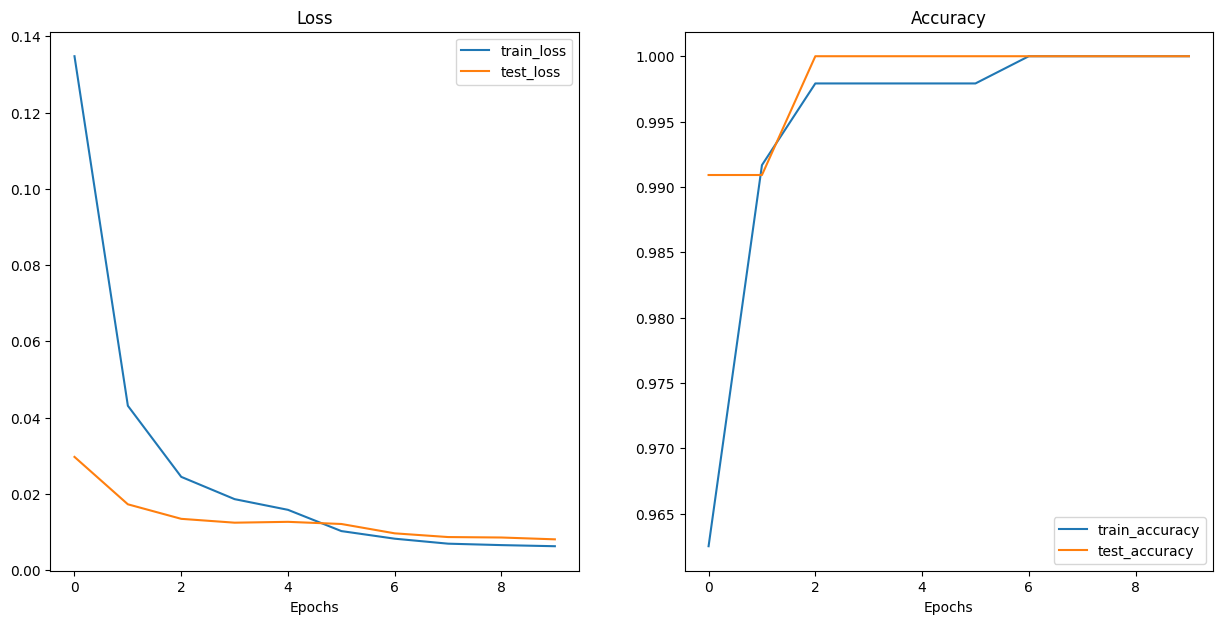

In [ ]:
plot_loss_curves(pretrained_vit_swag_results)

### 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:

* ImageNet-21k pretraining - To explore model scalability and see how large of a dataset we could use our transformer o
* Learning rate warmup - Learning rate warm-up involves gradually increasing the learning rate during the initial stages of training before letting it follow its scheduled decay
* Learning rate decay - Learning rate decay is a technique for training modern neural networks. It starts training the network with a large learning rate and then slowly reducing/decaying it until local minima is obtained.
* Gradient clipping - Gradient clipping is a technique that tackles exploding gradients. The idea of gradient clipping is very simple: If the gradient gets too large, we rescale it to keep it small.Exploding gradients refer to the problem that the gradients get too large in training, making the model unstable. Similarly, vanishing gradients refer to gradients getting too small in training. This prevents the network weights from changing their values. Both problems cause the model unable to learn from the training data.